In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Data Cleaning

In [2]:
sales = pd.read_parquet('sale_sample_18-21.parquet')
# township_codes = gpd.read_file('townships.geojson')
char_sample = pd.read_csv('char_sample.csv', dtype={'class': str}) # also has 'EX' in column
geo_info = pd.read_csv('parcels_geoinfo.csv')
cards = pd.read_csv('cards.csv')
cards.drop_duplicates(inplace=True)
# some are duplicates other than sqft and year built, same year and other info but diff sqft, so we drop it cuz this look anamolous
char_sample.drop_duplicates(subset=['year', 'pin','class'],inplace=True)

sales.year = sales.year.astype(int)
sales.pin = sales.pin.astype(int)
#sales.township = sales.township_code.astype(int)
#townships.township = townships.township.astype(int)
geo_info['class'] = geo_info['class'].astype(str)
geo_info.drop(['year'], axis=1,  inplace=True)
sales['class'] = sales['class'].astype(str)
sales.township_code = sales.township_code.astype(int)
sales = pd.merge(sales, geo_info, how='outer')
sales = pd.merge(sales, char_sample, )
sales = pd.merge(sales, cards)
sales = sales[sales['is_multisale'] != '1']
sales = sales[sales['card'] == 1]
sales.rename(columns = {'township_code_x': 'township_code'}, inplace=True)

In [3]:
sales

,pin,year,township_code,class,sale_date,sale_price,sale_price_log10,sale_key,doc_no,deed_type,...,is_homestead_exemption,homestead_exemption_general_alternative,homestead_exemption_senior_citizens,homestead_exemption_senior_citizens_assessment_freeze,census_tract_geoid,lat,lon,sqft,year_built,card
0,2092050370000,2019.0,29,295,2019-05-01 00:00:00+00:00,201000.0,5.303196,96812985.0,1915417094,01,...,0,0.0,0.0,0.0,NaN,NaN,NaN,1155.0,1985.0,1
2,10201120410000,2018.0,24,206,2018-07-01 00:00:00+00:00,540000.0,5.732394,97373057.0,1822817046,01,...,0,0.0,0.0,0.0,NaN,NaN,NaN,2256.0,1947.0,1
3,16183030040000,2022.0,27,203,2022-02-11 00:00:00+00:00,595000.0,5.774517,7321053.0,2206001050,01,...,None,NaN,NaN,NaN,NaN,NaN,NaN,1787.0,1918.0,1
4,10272320440000,2020.0,24,203,2020-04-01 00:00:00+00:00,285000.0,5.454845,96592558.0,2019607192,01,...,0,0.0,0.0,0.0,NaN,NaN,NaN,1332.0,1953.0,1
6,15011010390000,2020.0,33,234,2020-12-29 00:00:00+00:00,480000.0,5.681241,7127160.0,2102855154,01,...,0,0.0,0.0,0.0,NaN,NaN,NaN,2079.0,1888.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
221429,3081110200000,2019.0,38,295,2019-07-01 00:00:00+00:00,553125.0,5.742823,98482344.0,1919755022,05,...,0,0.0,0.0,0.0,1.703180e+10,42.134879,-87.981232,2089.0,2018.0,1
221430,25212060060000,2021.0,72,202,2021-07-07 00:00:00+00:00,61000.0,4.785330,7209461.0,2120021039,01,...,0,0.0,0.0,0.0,NaN,NaN,NaN,918.0,1899.0,1
221431,7294030160000,2021.0,35,278,2021-08-30 00:00:00+00:00,220000.0,5.342423,7249327.0,2126546039,01,...,0,0.0,0.0,0.0,1.703180e+10,42.010148,-88.116944,2330.0,1966.0,1
221432,13251310310000,2018.0,77,203,2018-05-01 00:00:00+00:00,625000.0,5.795880,96260041.0,1815912107,01,...,0,0.0,0.0,0.0,NaN,NaN,NaN,1102.0,1895.0,1


# Variance - Outlier Detection

Just check number of deivations away from mean grouped by township_code.

Problems:

Would like to vary by geography, but how to join new geographies to table to do that? What is value in common? With spatial dataset could see what PINS in what unit, but we have no lat/long for data.


In [4]:
def is_outlier_groupby(s: pd.Series, lower_lim : int, upper_lim: int) -> pd.DataFrame:
    """
    Finds values outside of std deviation range.
    Function meant for groupby() only.
    """
    lower_limit = s.mean() - (s.std() * lower_lim)
    upper_limit = s.mean() + (s.std() * upper_lim)
    return ~s.between(lower_limit, upper_limit)


def plot_std(df: pd.DataFrame, group: str, col: str, permuts: list) -> list:
    fig, ax = plt.subplots(figsize=(15,10), ncols=2, nrows=len(permuts))
    stats = []
    outs = {}

    for tup in range(len(permuts)):
        std_outliers = df.dropna(subset=[group, col])[df.groupby([group, 'class'])[col].apply(is_outlier_groupby, permuts[tup][0], permuts[tup][1])]
        no_std_outliers = df.dropna(subset=[group, col])[~df.groupby([group, 'class'])[col].apply(is_outlier_groupby, permuts[tup][0], permuts[tup][1])]
        std_outliers[col].plot.hist(ax=ax[tup, 0] )
        no_std_outliers[col].plot.hist(ax=ax[tup,1])
        fig.suptitle('Outliers - No Outliers')

        pct = len(std_outliers) / len(df.dropna(subset=[group, col]))
        stat = (len(std_outliers), pct)
        stats.append(stat)
        outs[permuts[tup]] = std_outliers

    print(stats)
    return outs


[(201, 0.008113344635504964), (296, 0.011948010010494874), (342, 0.01380479534996367), (883, 0.035642205538064096)]


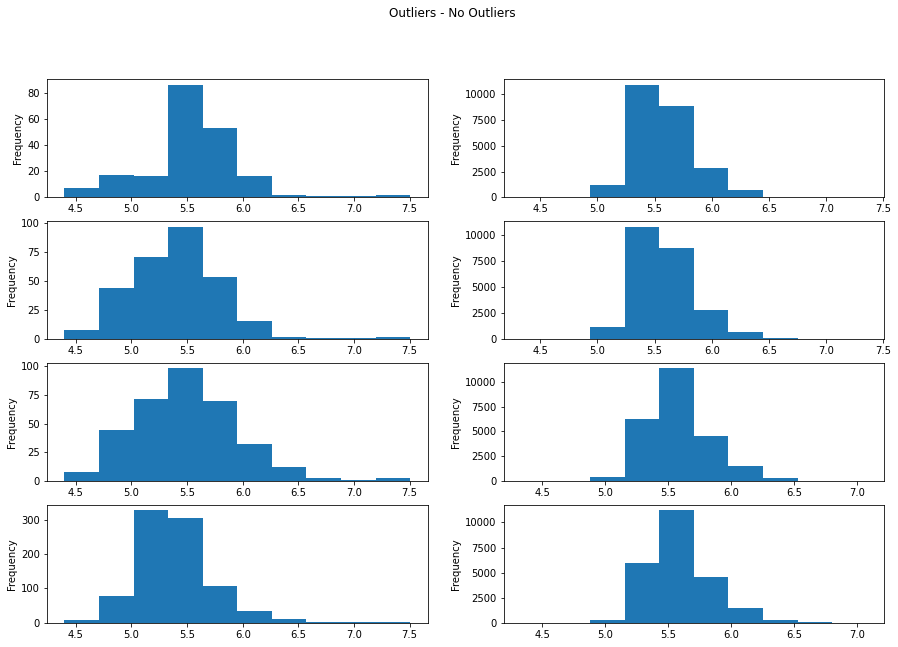

In [5]:
std_permutations = [(4,4), (3,4), (3,3), (2,3)]
census_sale_outs = plot_std(sales, 'census_tract_geoid', 'sale_price_log10', std_permutations)

[(481, 0.0023767170669038444), (1540, 0.007609447573870936), (1793, 0.008859571103864018), (7375, 0.03644134795928451)]


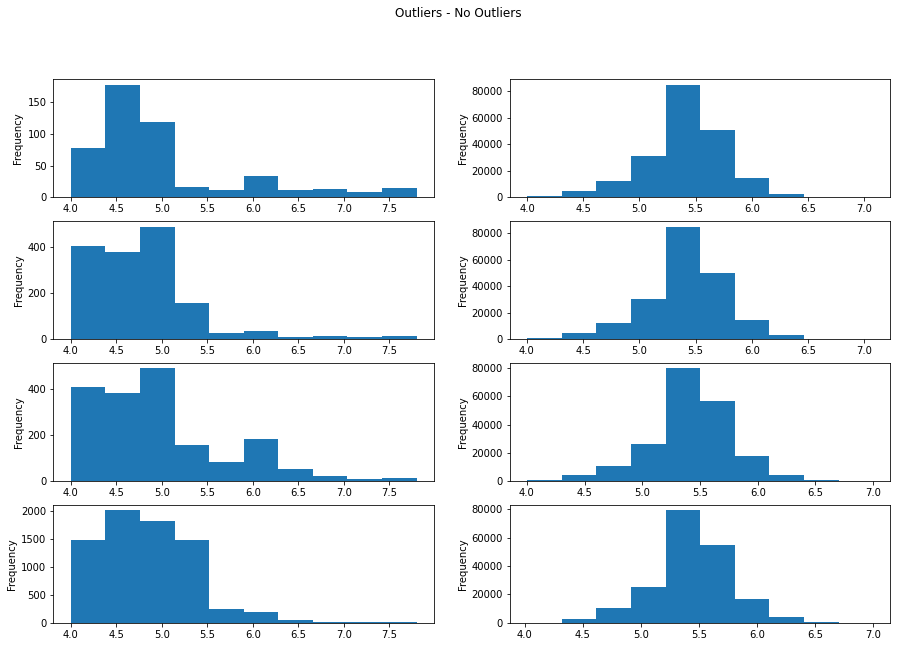

In [6]:
town_sale_outs = plot_std(sales, 'township_code', 'sale_price_log10', std_permutations)

### $ per sqft

In [7]:
sales['price_per_sqft'] = sales['sale_price'] / sales['sqft']
sales['price_per_sqft_log10'] = sales['sale_price_log10'] / sales['sqft']
sales['price_per_sqft'].replace([np.inf, -np.inf], np.nan, inplace=True)
sales['price_per_sqft_log10'].replace([np.inf, -np.inf], np.nan, inplace=True)

/tmp/ipykernel_2338616/2132625190.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  std_outliers = df.dropna(subset=[group, col])[df.groupby([group, 'class'])[col].apply(is_outlier_groupby, permuts[tup][0], permuts[tup][1])]
/tmp/ipykernel_2338616/2132625190.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  no_std_outliers = df.dropna(subset=[group, col])[~df.groupby([group, 'class'])[col].apply(is_outlier_groupby, permuts[tup][0], permuts[tup][1])]
/tmp/ipykernel_2338616/2132625190.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  std_outliers = df.dropna(subset=[group, col])[df.groupby([group, 'class'])[col].apply(is_outlier_groupby, permuts[tup][0], permuts[tup][1])]
/tmp/ipykernel_2338616/2132625190.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  no_std_outliers = df.dropna(subset=[group, col])[~df.groupby([group, 'class'])[col].apply(is_outl

[(318, 0.0015719073464424474), (476, 0.0023529179148006445), (1140, 0.005635139543850283), (3552, 0.017557908473470357)]


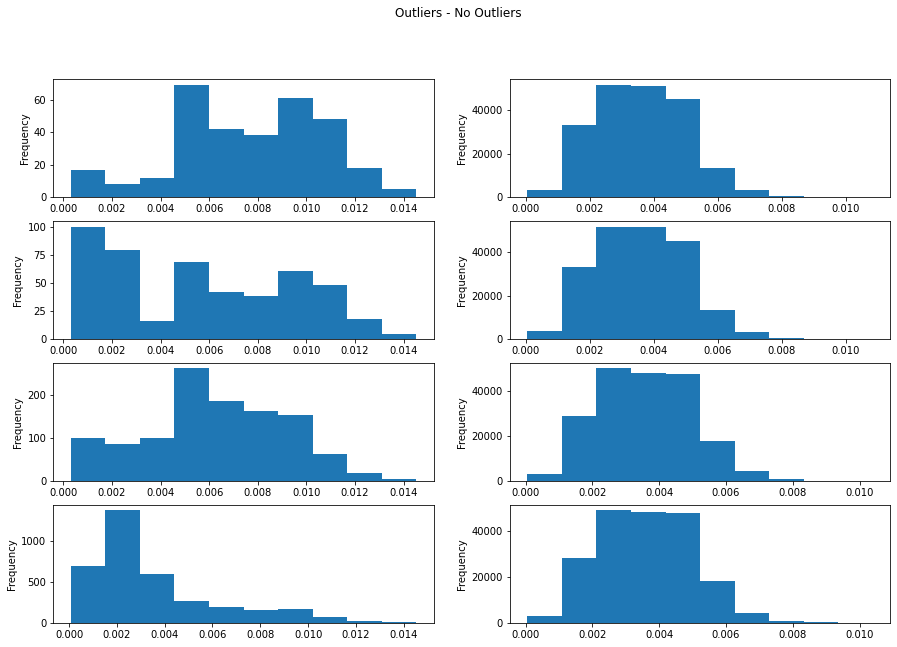

In [8]:
town_sqft_outs = plot_std(sales, 'township_code', 'price_per_sqft_log10', std_permutations)

[(169, 0.006821667877613628), (179, 0.00722531686445467), (225, 0.009082102203923468), (507, 0.020465003632840883)]


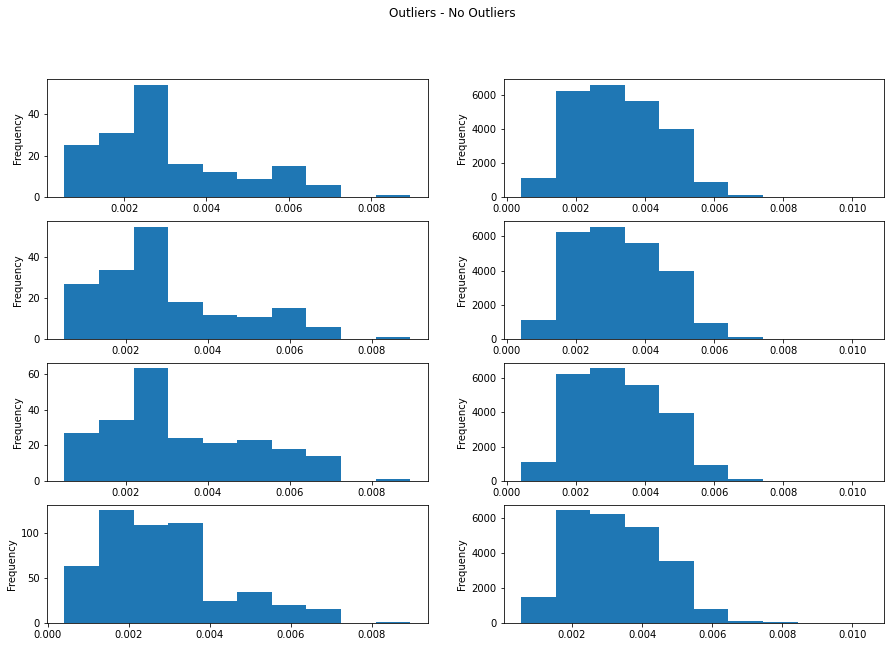

In [9]:
census_sqft_outs = plot_std(sales, 'census_tract_geoid', 'price_per_sqft_log10', std_permutations)

[(481, 0.0023767170669038444), (1540, 0.007609447573870936), (1793, 0.008859571103864018), (7375, 0.03644134795928451)]


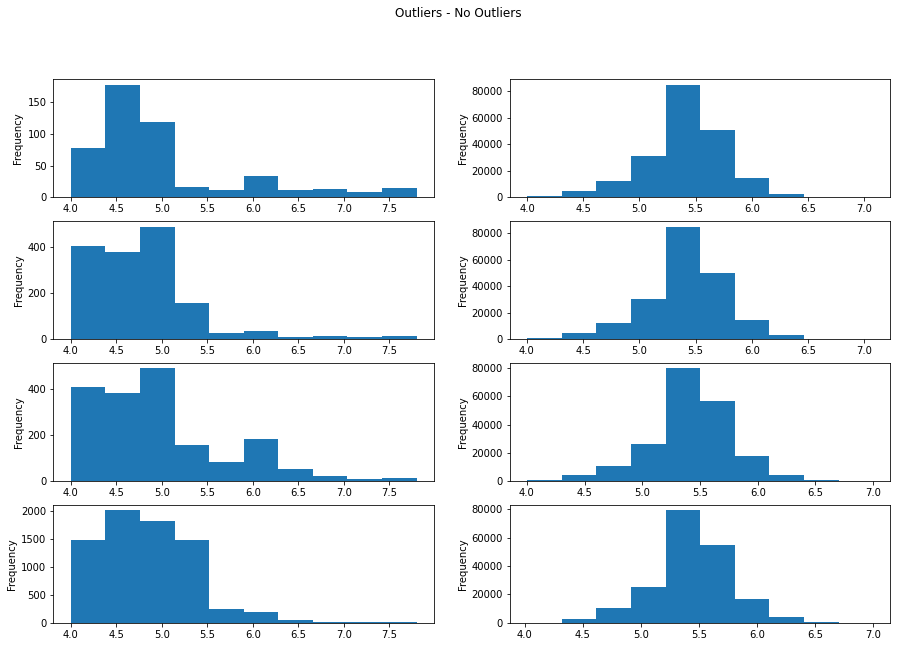

In [10]:
class_outs = plot_std(sales, 'township_code', 'sale_price_log10', std_permutations)

/tmp/ipykernel_2338616/2132625190.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  std_outliers = df.dropna(subset=[group, col])[df.groupby([group, 'class'])[col].apply(is_outlier_groupby, permuts[tup][0], permuts[tup][1])]
/tmp/ipykernel_2338616/2132625190.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  no_std_outliers = df.dropna(subset=[group, col])[~df.groupby([group, 'class'])[col].apply(is_outlier_groupby, permuts[tup][0], permuts[tup][1])]
/tmp/ipykernel_2338616/2132625190.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  std_outliers = df.dropna(subset=[group, col])[df.groupby([group, 'class'])[col].apply(is_outlier_groupby, permuts[tup][0], permuts[tup][1])]
/tmp/ipykernel_2338616/2132625190.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  no_std_outliers = df.dropna(subset=[group, col])[~df.groupby([group, 'class'])[col].apply(is_outl

[(339, 0.0016757125485660053), (441, 0.002179909244594715), (1097, 0.005422586034740141), (3116, 0.015402714753190775)]


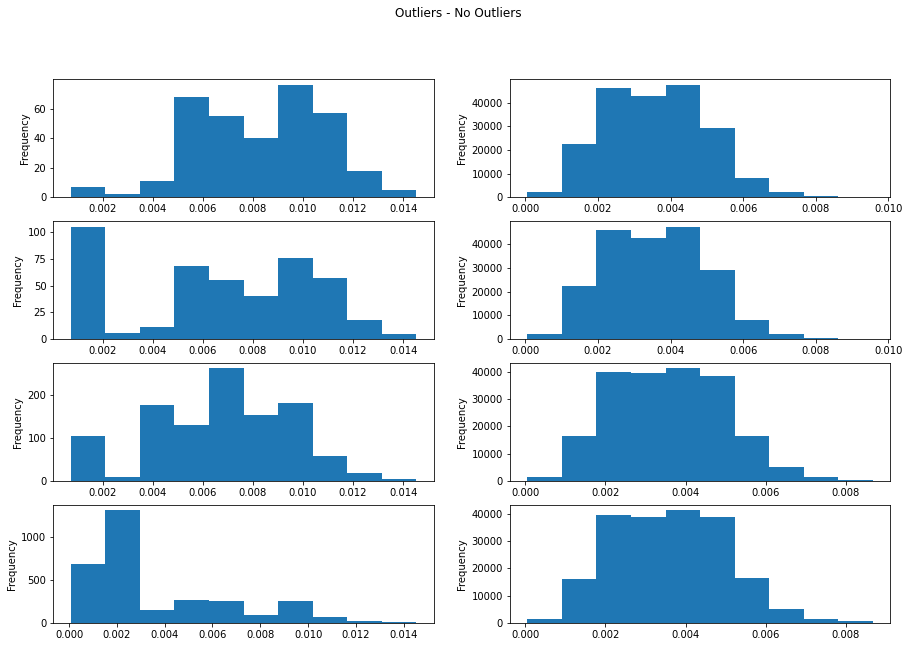

In [11]:
class_outs_sqft = plot_std(sales, 'class', 'price_per_sqft_log10', std_permutations)

#### Overlaps

In [12]:
# Between Township and Census for price
for tup in std_permutations:
    print(tup, len(town_sale_outs[tup]), len(census_sale_outs[tup]), len(pd.merge(town_sale_outs[tup], census_sale_outs[tup])))
# limits, length of first DF, length of 2nd DF, length of overlap

(4, 4) 481 201 25
(3, 4) 1540 296 86
(3, 3) 1793 342 109
(2, 3) 7375 883 416


In [13]:
# Between Township and Census for SQFT
for tup in std_permutations:
    print(tup, len(town_sqft_outs[tup]), len(census_sqft_outs[tup]), len(pd.merge(town_sqft_outs[tup], census_sqft_outs[tup])))
# limits, length of first DF, length of 2nd DF, length of overlap

(4, 4) 318 169 2
(3, 4) 476 179 4
(3, 3) 1140 225 22
(2, 3) 3552 507 112


In [14]:
# Within township for price and price/sqft
for tup in std_permutations:
    print(tup, len(town_sale_outs[tup]), len(town_sqft_outs[tup]), len(pd.merge(town_sale_outs[tup], town_sqft_outs[tup])))
# limits, length of first DF, length of 2nd DF, length of overlap

(4, 4) 481 318 13
(3, 4) 1540 476 35
(3, 3) 1793 1140 68
(2, 3) 7375 3552 472


In [15]:
# Within census for price and price/sqft
for tup in std_permutations:
    print(tup, len(census_sale_outs[tup]), len(census_sqft_outs[tup]), len(pd.merge(census_sale_outs[tup], census_sqft_outs[tup])))
# limits, length of first DF, length of 2nd DF, length of overlap

(4, 4) 201 169 160
(3, 4) 296 179 163
(3, 3) 342 225 170
(2, 3) 883 507 197


# Sale Volatility

Create buckets of which properties fall into which growth rates. Look at absolute value change, see if departing from value of area or moving towards.
See what portion of data illustrates particular outlier flag, and which ones illustrate several outlier flags.

In [16]:
sales['pct'] = sales.sort_values('sale_date').groupby('pin')['sale_price_log10'].pct_change()
township_avg_change = sales.groupby(['township_code'])['pct'].mean()
township_mean = sales.groupby(['township_code'])['sale_price_log10'].mean()
class_mean = sales.groupby(['class'])['sale_price_log10'].mean()
town_class_mean = sales.groupby(['township_code', 'class'])['sale_price_log10'].mean()


sales.set_index('township_code', inplace=True)
sales['township_avg_change'] = township_avg_change
sales['township_mean_sale_log10'] = township_mean
sales['diff_from_township_mean_sale_log10'] = abs(sales['township_mean_sale_log10'] - sales['sale_price_log10'])
sales.reset_index(inplace=True)

sales.set_index('class', inplace=True)
sales['class_mean_sale_log10'] = class_mean
sales['diff_from_class_mean_sale_log10'] = abs(sales['class_mean_sale_log10'] - sales['sale_price_log10'])
sales.reset_index(inplace=True)

sales.set_index(['township_code', 'class'], inplace=True)
sales['town_class_mean_sale_log10'] = town_class_mean
sales['diff_from_town_class_mean_sale_log10'] = abs(sales['town_class_mean_sale_log10'] - sales['sale_price_log10'])
sales.reset_index(inplace=True)

<AxesSubplot:ylabel='Frequency'>

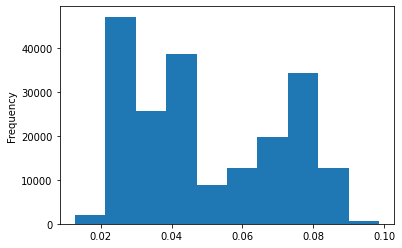

In [17]:
sales.township_avg_change.plot.hist()

## Between transactions for the same property

In [18]:
dups = sales[sales.pin.duplicated(keep=False)]

In [19]:
v_counts = dups.pin.value_counts().reset_index().rename(columns={'index':'pin', 'pin':'counts'})

In [20]:
def is_outlier_column(df: pd.DataFrame, col: str, lower_lim, upper_lim):
    """
    Function that calculates outliers for pandas columns.
    Contrat with is_outlier_groupby().
    """
    lower_limit = df[col].mean() - (df[col].std() * lower_lim)
    upper_limit = df[col].mean() + (df[col].std() * upper_lim)
    return df[~df[col].between(lower_limit, upper_limit)]


In [21]:
count_outliers = {}
for std in std_permutations:
    count_outliers[std] = is_outlier_column(v_counts, 'counts', std[0], std[1])

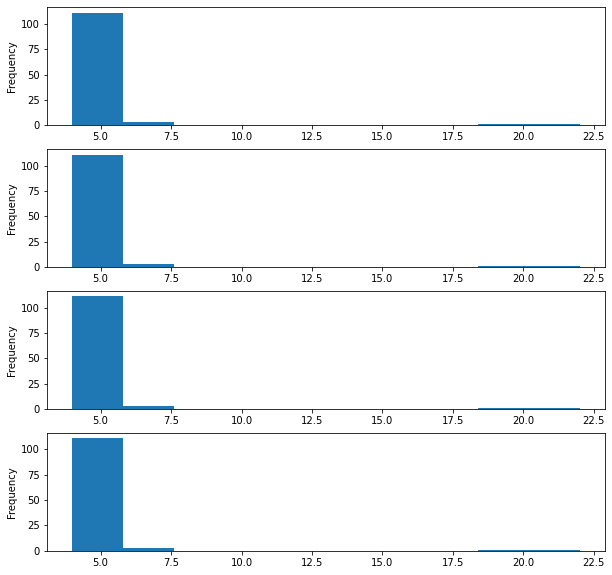

In [22]:
fig, ax = plt.subplots(figsize=(10,10), ncols=1, nrows=len(std_permutations))
for std in range(len(std_permutations)):
    count_outliers[std_permutations[std]].counts.plot.hist(ax=ax[std])

In [23]:
dups = pd.merge(dups, v_counts, how='outer')

/tmp/ipykernel_2338616/2132625190.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  std_outliers = df.dropna(subset=[group, col])[df.groupby([group, 'class'])[col].apply(is_outlier_groupby, permuts[tup][0], permuts[tup][1])]
/tmp/ipykernel_2338616/2132625190.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  no_std_outliers = df.dropna(subset=[group, col])[~df.groupby([group, 'class'])[col].apply(is_outlier_groupby, permuts[tup][0], permuts[tup][1])]
/tmp/ipykernel_2338616/2132625190.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  std_outliers = df.dropna(subset=[group, col])[df.groupby([group, 'class'])[col].apply(is_outlier_groupby, permuts[tup][0], permuts[tup][1])]
/tmp/ipykernel_2338616/2132625190.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  no_std_outliers = df.dropna(subset=[group, col])[~df.groupby([group, 'class'])[col].apply(is_outl

[(112, 0.004507586428945144), (154, 0.006197931339799573), (296, 0.011912906990783595), (462, 0.01859379401939872)]


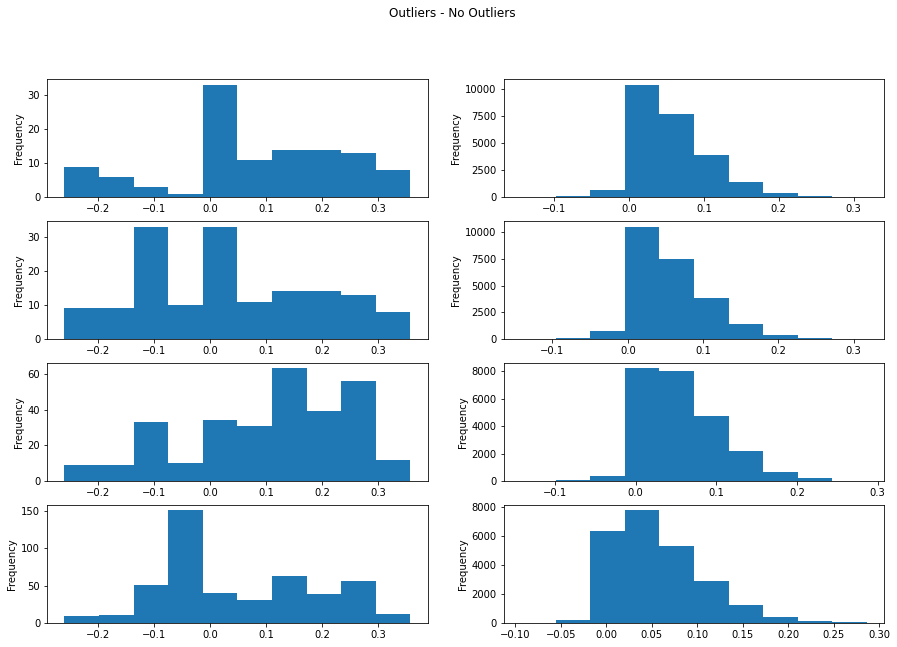

In [24]:
std_permutations = [(4,4), (3,4), (3,3), (2,3)]
volatile_outliers = plot_std(sales, 'township_code', 'pct', std_permutations)

In [25]:
volatile_outliers[(2,3)]

,township_code,class,pin,year,sale_date,sale_price,sale_price_log10,sale_key,doc_no,deed_type,...,price_per_sqft,price_per_sqft_log10,pct,township_avg_change,township_mean_sale_log10,diff_from_township_mean_sale_log10,class_mean_sale_log10,diff_from_class_mean_sale_log10,town_class_mean_sale_log10,diff_from_town_class_mean_sale_log10
146,77,278,16032160430000,2021.0,2021-07-19 00:00:00+00:00,397500.0,5.599337,7226615.0,2121725028,01,...,187.323280,0.002639,0.242875,0.066830,5.484353,0.114984,5.699481,0.100144,6.030444,0.431106
602,73,205,14193270030000,2021.0,2021-06-14 00:00:00+00:00,100000.0,5.000000,7219182.0,2121441044,01,...,47.014575,0.002351,-0.157109,0.023905,5.943484,0.943484,5.433573,0.433573,5.860862,0.860862
838,70,202,20254300190000,2020.0,2020-07-01 00:00:00+00:00,37000.0,4.568202,96629177.0,2026007264,01,...,41.666667,0.005144,-0.100172,0.086418,5.125809,0.557607,5.152254,0.584052,4.942774,0.374573
929,71,204,13292140080000,2020.0,2020-07-01 00:00:00+00:00,325000.0,5.511883,97334007.0,2026212201,05,...,158.227848,0.002683,0.223463,0.040789,5.569115,0.057232,5.554777,0.042893,5.605775,0.093892
1480,32,202,31172140180000,2020.0,2020-03-01 00:00:00+00:00,90500.0,4.956649,96146890.0,2007308320,05,...,93.202884,0.005105,-0.042505,0.063105,5.137513,0.180864,5.152254,0.195605,4.805071,0.151577
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182124,12,203,32251060040000,2019.0,2019-03-01 00:00:00+00:00,130000.0,5.113943,97962379.0,1908808118,01,...,126.953125,0.004994,0.270707,0.067328,5.079560,0.034384,5.303808,0.189865,5.032502,0.081442
187395,72,211,20204220270000,2021.0,2021-04-30 00:00:00+00:00,326000.0,5.513218,7177551.0,2113018294,01,...,128.346457,0.002171,0.345701,0.080549,5.165007,0.348210,5.438214,0.075004,5.153093,0.360124
198197,19,208,22243060050000,2021.0,2021-11-03 00:00:00+00:00,402000.0,5.604226,7280716.0,2133501110,01,...,81.657526,0.001138,0.008134,0.025160,5.589784,0.014442,5.957802,0.353576,5.814292,0.210066
199917,20,205,12254100160000,2021.0,2021-07-20 00:00:00+00:00,625000.0,5.795880,7228673.0,2122134072,05,...,347.029428,0.003218,0.175773,0.041963,5.400142,0.395738,5.433573,0.362307,5.412630,0.383250


## Length of Property Holding

In [26]:
sales['days_since_last_transaction'] = sales.sort_values('sale_date').groupby('pin')['sale_date'].diff().apply(lambda x: x.days)

<AxesSubplot:ylabel='Frequency'>

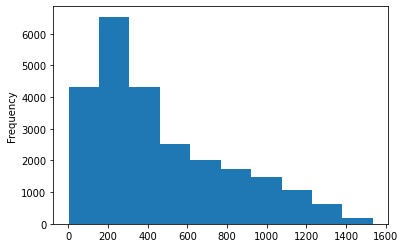

In [27]:
sales.days_since_last_transaction.plot.hist()

In [28]:
sales.days_since_last_transaction.describe()

count    24847.000000
mean       467.211937
std        342.275104
min          1.000000
25%        212.000000
50%        365.000000
75%        688.000000
max       1536.000000
Name: days_since_last_transaction, dtype: float64

/tmp/ipykernel_2338616/2132625190.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  std_outliers = df.dropna(subset=[group, col])[df.groupby([group, 'class'])[col].apply(is_outlier_groupby, permuts[tup][0], permuts[tup][1])]
/tmp/ipykernel_2338616/2132625190.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  no_std_outliers = df.dropna(subset=[group, col])[~df.groupby([group, 'class'])[col].apply(is_outlier_groupby, permuts[tup][0], permuts[tup][1])]
/tmp/ipykernel_2338616/2132625190.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  std_outliers = df.dropna(subset=[group, col])[df.groupby([group, 'class'])[col].apply(is_outlier_groupby, permuts[tup][0], permuts[tup][1])]
/tmp/ipykernel_2338616/2132625190.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  no_std_outliers = df.dropna(subset=[group, col])[~df.groupby([group, 'class'])[col].apply(is_outl

[(50, 0.0020123153700647967), (50, 0.0020123153700647967), (161, 0.006479655491608645), (167, 0.00672113333601642)]


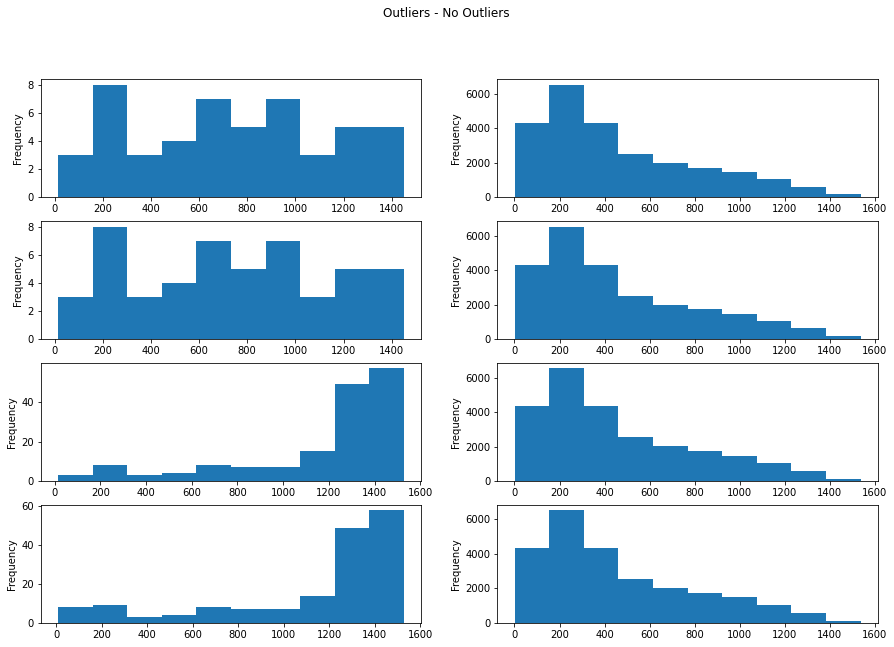

In [29]:
holding_outliers = plot_std(sales, 'township_code', 'days_since_last_transaction', std_permutations)

/tmp/ipykernel_2338616/2132625190.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  std_outliers = df.dropna(subset=[group, col])[df.groupby([group, 'class'])[col].apply(is_outlier_groupby, permuts[tup][0], permuts[tup][1])]
/tmp/ipykernel_2338616/2132625190.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  no_std_outliers = df.dropna(subset=[group, col])[~df.groupby([group, 'class'])[col].apply(is_outlier_groupby, permuts[tup][0], permuts[tup][1])]
/tmp/ipykernel_2338616/2132625190.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  std_outliers = df.dropna(subset=[group, col])[df.groupby([group, 'class'])[col].apply(is_outlier_groupby, permuts[tup][0], permuts[tup][1])]
/tmp/ipykernel_2338616/2132625190.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  no_std_outliers = df.dropna(subset=[group, col])[~df.groupby([group, 'class'])[col].apply(is_outl

[(3, 0.0001207389222038878), (3, 0.0001207389222038878), (81, 0.0032599508995049702), (81, 0.0032599508995049702)]


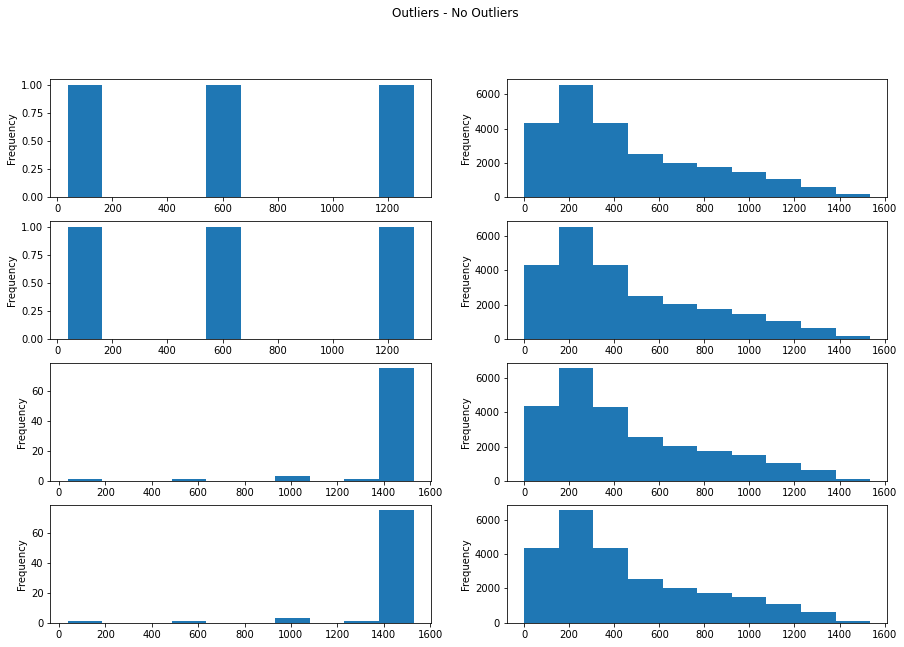

In [30]:
class_holding_outliers = plot_std(sales, 'class', 'days_since_last_transaction', std_permutations)

## Growth Rates

In [31]:
dates = dups.groupby('pin')['sale_date'].agg(['first','last']).reset_index()

In [32]:
firsts = dates[['pin', 'first']].copy()
firsts.rename(columns= {'first': 'sale_date'}, inplace=True)
lasts = dates[['pin', 'last']].copy()
lasts.rename(columns= {'last': 'sale_date'}, inplace=True)

In [33]:
first_transactions = pd.merge(dups, firsts)
last_tranasactions = pd.merge(dups, lasts)

In [34]:
t = last_tranasactions.pin.value_counts()
last_tranasactions = last_tranasactions[last_tranasactions.pin.isin(t.index[~t.gt(1)])]
t = first_transactions.pin.value_counts()
first_transactions = first_transactions[first_transactions.pin.isin(t.index[~t.gt(1)])]

In [35]:
transactions = pd.concat([first_transactions, last_tranasactions], ignore_index=True)

In [36]:
transactions['total_pct'] = transactions.sort_values('sale_date').groupby('pin')['sale_price_log10'].pct_change()
transactions.total_pct.mean()

0.059575298420999435

In [37]:
transactions.total_pct.describe()

count    22932.000000
mean         0.059575
std          0.052301
min         -0.259433
25%          0.019552
50%          0.049256
75%          0.088579
max          0.357581
Name: total_pct, dtype: float64

In [38]:
transactions[transactions.township_code == 76].total_pct.describe()

count    228.000000
mean       0.042877
std        0.043942
min       -0.029395
25%        0.009533
50%        0.026220
75%        0.065170
max        0.234988
Name: total_pct, dtype: float64

<AxesSubplot:ylabel='Frequency'>

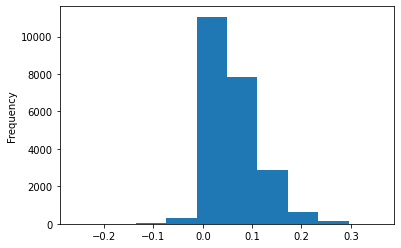

In [39]:
transactions.total_pct.plot.hist()

In [40]:
transactions.groupby('township_code')['total_pct'].median()

township_code
10    0.011033
11    0.050742
12    0.065982
13    0.048659
14    0.103083
15    0.066685
16    0.028825
17    0.025390
18    0.026839
19    0.015712
20    0.038635
21    0.032952
22    0.024333
23    0.019051
24    0.029016
25    0.017936
26    0.026084
27    0.022206
28    0.019262
29    0.017248
30    0.032419
31    0.051845
32    0.065155
33    0.008306
34    0.034318
35    0.025445
36    0.045865
37    0.082194
38    0.022696
39    0.042987
70    0.093108
71    0.038696
72    0.080432
73    0.012013
74    0.005406
75    0.020761
76    0.026220
77    0.068692
Name: total_pct, dtype: float64

/tmp/ipykernel_2338616/2132625190.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  std_outliers = df.dropna(subset=[group, col])[df.groupby([group, 'class'])[col].apply(is_outlier_groupby, permuts[tup][0], permuts[tup][1])]
/tmp/ipykernel_2338616/2132625190.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  no_std_outliers = df.dropna(subset=[group, col])[~df.groupby([group, 'class'])[col].apply(is_outlier_groupby, permuts[tup][0], permuts[tup][1])]
/tmp/ipykernel_2338616/2132625190.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  std_outliers = df.dropna(subset=[group, col])[df.groupby([group, 'class'])[col].apply(is_outlier_groupby, permuts[tup][0], permuts[tup][1])]
/tmp/ipykernel_2338616/2132625190.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  no_std_outliers = df.dropna(subset=[group, col])[~df.groupby([group, 'class'])[col].apply(is_outl

[(110, 0.004796790511076225), (143, 0.006235827664399093), (288, 0.012558869701726845), (438, 0.019099947671376242)]


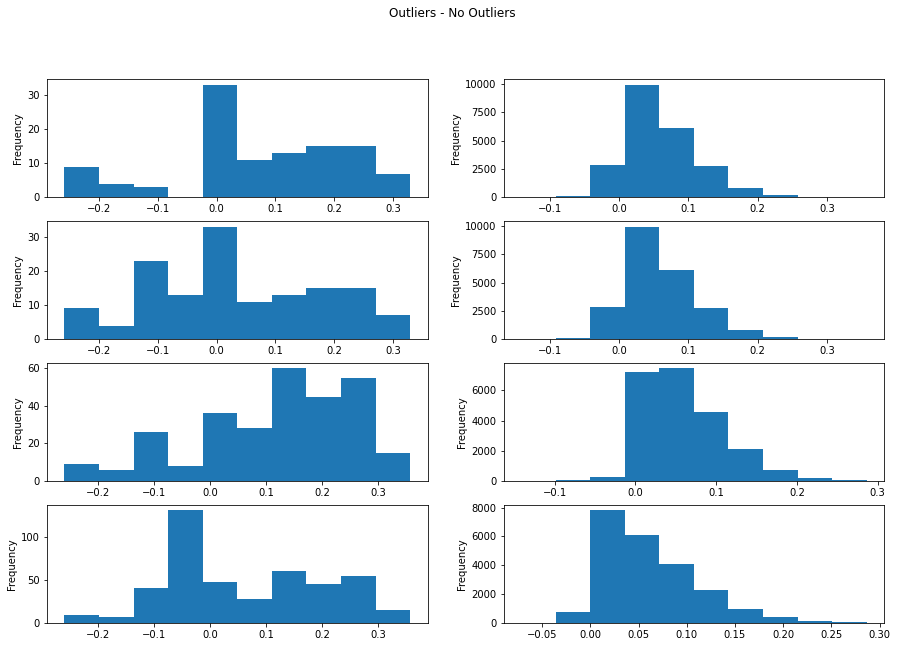

In [41]:
town_growth = plot_std(transactions, 'township_code', 'total_pct', std_permutations)

/tmp/ipykernel_2338616/2132625190.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  std_outliers = df.dropna(subset=[group, col])[df.groupby([group, 'class'])[col].apply(is_outlier_groupby, permuts[tup][0], permuts[tup][1])]
/tmp/ipykernel_2338616/2132625190.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  no_std_outliers = df.dropna(subset=[group, col])[~df.groupby([group, 'class'])[col].apply(is_outlier_groupby, permuts[tup][0], permuts[tup][1])]
/tmp/ipykernel_2338616/2132625190.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  std_outliers = df.dropna(subset=[group, col])[df.groupby([group, 'class'])[col].apply(is_outlier_groupby, permuts[tup][0], permuts[tup][1])]
/tmp/ipykernel_2338616/2132625190.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  no_std_outliers = df.dropna(subset=[group, col])[~df.groupby([group, 'class'])[col].apply(is_outl

[(263, 0.13501026694045173), (263, 0.13501026694045173), (263, 0.13501026694045173), (265, 0.1360369609856263)]


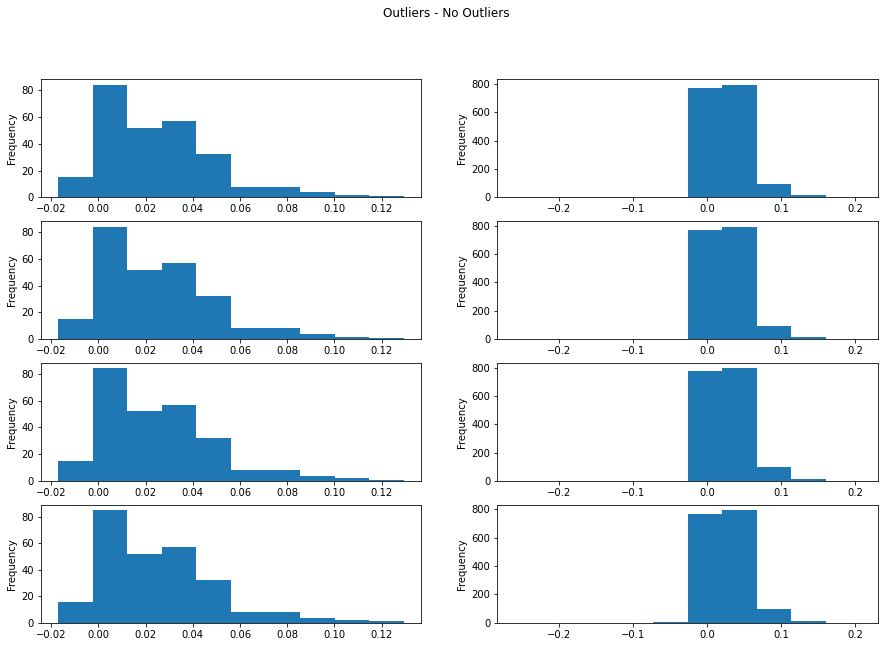

In [42]:
census_growth = plot_std(transactions, 'census_tract_geoid', 'total_pct', std_permutations)

## Moving Towards/Away From Mean

In [43]:
temp = dups.sort_values('sale_date').groupby(['pin'])['diff_from_township_mean_sale_log10'].shift()
dups['town_movement'] = dups['diff_from_township_mean_sale_log10'].lt(temp).astype(float) # 0 is moving away, 1 is moving towards

temp = dups.sort_values('sale_date').groupby(['pin'])['diff_from_class_mean_sale_log10'].shift()
dups['class_movement'] = dups['diff_from_class_mean_sale_log10'].lt(temp).astype(float) # 0 is moving away, 1 is moving towards

temp = dups.sort_values('sale_date').groupby(['pin'])['diff_from_town_class_mean_sale_log10'].shift()
dups['town_class_movement'] = dups['diff_from_town_class_mean_sale_log10'].lt(temp).astype(float) # 0 is moving away, 1 is moving towards


In [44]:
dups.town_class_movement.value_counts()

0.0    33437
1.0    14342
Name: town_class_movement, dtype: int64

In [45]:
sales['class'].value_counts()

203    61962
211    28627
202    20824
278    17821
234    16839
205    14309
295    13904
204     8892
206     6464
207     5065
210     2490
208     2290
212     1676
209     1039
297      163
218        6
213        5
299        3
219        1
Name: class, dtype: int64

In [46]:
sales = pd.merge(sales, dups, how='outer')
sales

,township_code,class,pin,year,sale_date,sale_price,sale_price_log10,sale_key,doc_no,deed_type,...,diff_from_township_mean_sale_log10,class_mean_sale_log10,diff_from_class_mean_sale_log10,town_class_mean_sale_log10,diff_from_town_class_mean_sale_log10,days_since_last_transaction,counts,town_movement,class_movement,town_class_movement
0,29,295,2092050370000,2019.0,2019-05-01 00:00:00+00:00,201000.0,5.303196,96812985.0,1915417094,01,...,0.215701,5.447748,0.144552,5.419923,0.116727,NaN,NaN,NaN,NaN,NaN
1,24,206,10201120410000,2018.0,2018-07-01 00:00:00+00:00,540000.0,5.732394,97373057.0,1822817046,01,...,0.174768,5.818391,0.085997,5.776303,0.043909,NaN,NaN,NaN,NaN,NaN
2,27,203,16183030040000,2022.0,2022-02-11 00:00:00+00:00,595000.0,5.774517,7321053.0,2206001050,01,...,0.125216,5.303808,0.470709,5.558610,0.215907,NaN,NaN,NaN,NaN,NaN
3,24,203,10272320440000,2020.0,2020-04-01 00:00:00+00:00,285000.0,5.454845,96592558.0,2019607192,01,...,0.102781,5.303808,0.151036,5.502140,0.047295,NaN,NaN,NaN,NaN,NaN
4,33,234,15011010390000,2020.0,2020-12-29 00:00:00+00:00,480000.0,5.681241,7127160.0,2102855154,01,...,0.131970,5.352436,0.328805,5.790492,0.109250,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202375,38,295,3081110200000,2019.0,2019-07-01 00:00:00+00:00,553125.0,5.742823,98482344.0,1919755022,05,...,0.202888,5.447748,0.295075,5.420874,0.321950,NaN,NaN,NaN,NaN,NaN
202376,72,202,25212060060000,2021.0,2021-07-07 00:00:00+00:00,61000.0,4.785330,7209461.0,2120021039,01,...,0.379678,5.152254,0.366924,5.080887,0.295557,NaN,NaN,NaN,NaN,NaN
202377,35,278,7294030160000,2021.0,2021-08-30 00:00:00+00:00,220000.0,5.342423,7249327.0,2126546039,01,...,0.110084,5.699481,0.357058,5.617934,0.275511,NaN,NaN,NaN,NaN,NaN
202378,77,203,13251310310000,2018.0,2018-05-01 00:00:00+00:00,625000.0,5.795880,96260041.0,1815912107,01,...,0.311527,5.303808,0.492072,5.322515,0.473365,NaN,NaN,NaN,NaN,NaN


## Human-Readable DataFrame Construction

In [47]:
std_permutations = [(4,4), (3,4), (3,3), (2,3), (2,2), (1,2), (1,1), (1,0), (2,0), (3,0), (4,0), (0,1), (0,2), (0,3), (0,4)]
sales_iterates = ['sale_price_log10', 'price_per_sqft_log10', 'days_since_last_transaction']
dups_iterates = ['counts', 'pct']
pd_data = {}
non_overs = {}

def sep_std(df: pd.DataFrame, group: str, col: str, permuts: tuple) -> (int, float):

    if col == 'pct':
        df = df[df.town_class_movement == 0]
    std_outliers = df.dropna(subset=[group, col])[df.groupby([group, 'class'])[col].apply(is_outlier_groupby, permuts[0], permuts[1])]

    pct = round(len(std_outliers) / len(sales), 3)

    length = len(std_outliers)

    return length, pct

sale = {}
for sal in sales_iterates:
    pd_data.setdefault(sal, [])
    pd_data.setdefault(sal + '_pct', [])
    for std in std_permutations:
        length, stat = sep_std(sales, 'township_code', sal, std)
        pd_data[sal].append(length)
        pd_data[sal + '_pct'].append(stat)

dupie = {}
for dup in dups_iterates:
    pd_data.setdefault(dup, [])
    pd_data.setdefault(dup + '_pct', [])
    for std in std_permutations:
        length, stat = sep_std(dups, 'township_code', dup, std)
        pd_data[dup].append(length)
        pd_data[dup + '_pct'].append(stat)

transac = {}
for trac in ['total_pct']:
    pd_data.setdefault(trac, [])
    pd_data.setdefault(trac + '_pct', [])
    for std in std_permutations:
        length, stat = sep_std(transactions, 'township_code', trac, std)
        pd_data[trac].append(length)
        pd_data[trac + '_pct'].append(stat)


def over_std(df: pd.DataFrame, group: str, col: str, permuts: tuple) -> (pd.DataFrame):

    if col == 'pct':
        df = df[df.town_class_movement == 0]
    std_outliers = df.dropna(subset=[group, col])[df.groupby([group, 'class'])[col].apply(is_outlier_groupby, permuts[0], permuts[1])]

    return std_outliers

for std in std_permutations:
    outties = []
    for it in sales_iterates + dups_iterates:
        if it in dups_iterates:
            outties.append(over_std(dups, 'township_code', it, std))
        else:
            outties.append(over_std(sales, 'township_code', it, std))
        all_outs = pd.concat(outties).drop_duplicates()
        non_overs[std] = len(sales[~sales.sale_key.isin(all_outs.sale_key)])

human = pd.DataFrame(pd_data, index=std_permutations)
human = human.assign(non_flagged=list(non_overs.values()))

/tmp/ipykernel_2338616/309808176.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  std_outliers = df.dropna(subset=[group, col])[df.groupby([group, 'class'])[col].apply(is_outlier_groupby, permuts[0], permuts[1])]
/tmp/ipykernel_2338616/309808176.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  std_outliers = df.dropna(subset=[group, col])[df.groupby([group, 'class'])[col].apply(is_outlier_groupby, permuts[0], permuts[1])]
/tmp/ipykernel_2338616/309808176.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  std_outliers = df.dropna(subset=[group, col])[df.groupby([group, 'class'])[col].apply(is_outlier_groupby, permuts[0], permuts[1])]
/tmp/ipykernel_2338616/309808176.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  std_outliers = df.dropna(subset=[group, col])[df.groupby([group, 'class'])[col].apply(is_outlier_groupby, permuts[0], permuts[1])]
/tmp

In [48]:
sides = ['both','both','both','both','both', 'both', 'both', 'left', 'left', 'left', 'left', 'right','right', 'right', 'right']
human.reset_index(inplace=True)
human['side'] = sides

In [49]:
human

,index,sale_price_log10,sale_price_log10_pct,price_per_sqft_log10,price_per_sqft_log10_pct,days_since_last_transaction,days_since_last_transaction_pct,counts,counts_pct,pct,pct_pct,total_pct,total_pct_pct,non_flagged,side
0,"(4, 4)",481,0.002,318,0.002,50,0.000,350,0.002,80,0.000,110,0.001,201147,both
1,"(3, 4)",1540,0.008,476,0.002,50,0.000,350,0.002,125,0.001,143,0.001,199928,both
2,"(3, 3)",1793,0.009,1140,0.006,161,0.001,999,0.005,147,0.001,288,0.001,198305,both
3,"(2, 3)",7375,0.036,3552,0.018,167,0.001,1004,0.005,293,0.001,438,0.002,190738,both
4,"(2, 2)",9377,0.046,6505,0.032,1216,0.006,4101,0.020,523,0.003,1008,0.005,182556,both
5,"(1, 2)",31268,0.155,35906,0.177,4074,0.020,4132,0.020,1469,0.007,3807,0.019,137089,both
6,"(1, 1)",54307,0.268,64077,0.317,7310,0.036,5228,0.026,2771,0.014,6359,0.031,98910,both
7,"(1, 0)",139776,0.691,130958,0.647,12650,0.063,5383,0.027,6095,0.030,13530,0.067,19133,left
8,"(2, 0)",117885,0.582,101557,0.502,9792,0.048,5352,0.026,5149,0.025,10731,0.053,34340,left
9,"(3, 0)",112303,0.555,99145,0.490,9786,0.048,5347,0.026,5003,0.025,10581,0.052,38000,left


## Overlaps

In [50]:
std_permutations = [(4,4), (3,4), (3,3), (2,3), (2,2), (1,2), (1,1), (1,0), (2,0), (3,0), (4,0), (0,1), (0,2), (0,3), (0,4)]

def overlap(group: str, cols: list, permut: tuple) -> pd.DataFrame:
    """
    cols is list where all values get concat together once groupby done.
    """
    sales_iterates = ['sale_price_log10', 'price_per_sqft_log10', 'days_since_last_transaction']
    dups_iterates = ['counts', 'pct']

    conc = []
    for c in cols:
        if c in sales_iterates:
            conc.append(sales.dropna(subset=[group, c])[sales.groupby([group, 'class'])[c].apply(is_outlier_groupby, permut[0], permut[1])])
        else:
            conc.append(dups.dropna(subset=[group, c])[dups.groupby([group, 'class'])[c].apply(is_outlier_groupby, permut[0], permut[1])])

    concated = pd.concat(conc, ignore_index=True)
    concated.pin.value_counts()
    v_counts = concated.sale_key.value_counts().reset_index().rename(columns={'index':'sale_key', 'sale_key':'counts'})

    return v_counts

flag_counts = []

for std in std_permutations:
    flags = overlap('township_code', sales_iterates + dups_iterates, std)
    index_length = [std] * len(flags)
    flags['permutation'] = index_length
    flags.set_index('permutation')
    flag_counts.append(flags)

flags_perms = pd.concat(flag_counts)

/tmp/ipykernel_2338616/3075294358.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  conc.append(sales.dropna(subset=[group, c])[sales.groupby([group, 'class'])[c].apply(is_outlier_groupby, permut[0], permut[1])])
/tmp/ipykernel_2338616/3075294358.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  conc.append(sales.dropna(subset=[group, c])[sales.groupby([group, 'class'])[c].apply(is_outlier_groupby, permut[0], permut[1])])
/tmp/ipykernel_2338616/3075294358.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  conc.append(dups.dropna(subset=[group, c])[dups.groupby([group, 'class'])[c].apply(is_outlier_groupby, permut[0], permut[1])])
/tmp/ipykernel_2338616/3075294358.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  conc.append(sales.dropna(subset=[group, c])[sales.groupby([group, 'class'])[c].apply(is_outlier_groupby, permut[0], permut[1])])
/tmp/ipyke

In [51]:
flags_perms[flags_perms.permutation == (0,4)]

,sale_key,counts,permutation
0,98481994.0,5,"(0, 4)"
1,98371252.0,5,"(0, 4)"
2,96963910.0,5,"(0, 4)"
3,7303480.0,5,"(0, 4)"
4,98334375.0,5,"(0, 4)"
...,...,...,...
164919,96928496.0,1,"(0, 4)"
164920,97814799.0,1,"(0, 4)"
164921,96816696.0,1,"(0, 4)"
164922,96556271.0,1,"(0, 4)"


<AxesSubplot:ylabel='Frequency'>

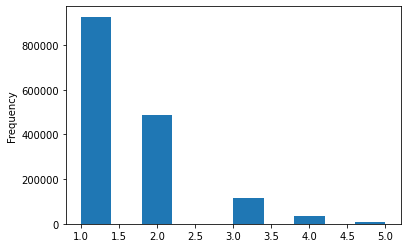

In [52]:
# make histograms
# what are axis?
flags_perms.counts.plot.hist()

In [53]:
sales_iterates = ['sale_price_log10', 'price_per_sqft_log10'] # 'days_since_last_transaction']
dups_iterates = ['counts', 'pct']

In [54]:
running = 0
for col in sales_iterates + dups_iterates:
    running += sales[col].std()
    print(running)

mean = running / len(sales_iterates + dups_iterates)
mean

0.3529591739568672
0.3543648654818226
1.0280470066205283
1.079280500947718


0.2698201252369295

## Microdata Columns

In [55]:
def get_thresh(df: pd.DataFrame, cols: list, permut: tuple):
    stds = {}

    for col in cols:
        grouped = df.dropna(subset=['township_code', col]).groupby(['township_code', 'class'])[col]
        lower_limit = grouped.mean() - (grouped.std() * permut[0])
        upper_limit = grouped.mean() + (grouped.std() * permut[1])
        std = grouped.std()

        lower_limit = lower_limit.to_dict()
        upper_limit = upper_limit.to_dict()
        std = std.to_dict()

        limits =  {x: (std.get(x, 0), lower_limit.get(x, 0), upper_limit.get(x, 0))
                    for x in set(std).union(upper_limit, lower_limit)}
        stds[col] = limits

    return stds

def over_std(df: pd.DataFrame, group: str, cols: list, permuts: tuple) -> (pd.DataFrame):
    outties = []

    for col in cols:
        if col == 'pct':
            df = df[df.town_class_movement == 0]
        outties.append(df.dropna(subset=[group, col])[df.groupby([group, 'class'])[col].apply(is_outlier_groupby, permuts[0], permuts[1])])

    all_outs = pd.concat(outties).drop_duplicates()

    return all_outs


In [56]:
from scipy.stats import zscore
columns = ['sale_price_log10', 'price_per_sqft_log10', 'pct', 'counts', 'days_since_last_transaction']
for col in columns:
    sales[col + '_zscore'] = zscore(sales[col], nan_policy='omit')

In [57]:
labels = {
    'pct_zscore': 'Price Change Outlier',
    'sale_price_log10_zscore' : 'Raw Price Outlier',
    'price_per_sqft_log10_zscore': 'Price/SQFT Outlier', 
    'counts_zscore': 'Transaction Volatility Outlier',
    'days_since_last_transaction_zscore': 'Days Since Last Transaction Outlier'}

columns = ['sale_price_log10_zscore', 'price_per_sqft_log10_zscore', 'pct_zscore', 'counts_zscore', 'days_since_last_transaction_zscore']
holds = get_thresh(sales, columns, (2,3))
outs = over_std(sales, 'township_code', columns, (2,3))
sale_outs = outs.sale_key.to_list()

def primary_outlier(row: pd.Series, thresholds: dict, outliers: pd.DataFrame, columns: list, labels: dict):
    """
    Meant to be used as .apply() function for a pd.DataFrame.
    Determines the primary outlier for a record by finding
    largest diff between record and std deviation of relevant column.
    Inputs:
        row (object): the row of the dataframe to be evaluated (passed from .apply()).
        thresholds (dict): dictionary of thresholds containing (lower_limit, upper_limit, std)
                          Generated by get_thresh().
        outliers (list): list containing the sale_key of all outliers for this column-set
                                 and std deviation permutation.
        columns (list): column-set to be used for this function
                        (should be same as used in get_thresh(), over_std()).
        labels (dict): labels for column. Key is the name of a column,
                       value is the label to be mapped to that column if it is an outlier.
    Outputs:
        value (str): Value of the primary_outlier column.
                     Chosen from labels.
    """

    if row['sale_key'] not in outliers:
        value = 'Not Outlier'
    else:
        stds = {}
        for col in columns:
            if thresholds.get(col).get((row['township_code'], row['class'])) and pd.notnull(row[col]):
                std, *std_range = thresholds.get(col).get((row['township_code'], row['class']))
                stds[col] = abs(std)

        highest = max(stds, key=stds.get)
        value = labels[highest]

    return value

sales['primary_outlier'] = sales.apply(primary_outlier, args=(holds, sale_outs, columns, labels), axis=1)

/tmp/ipykernel_2338616/4278548875.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  outties.append(df.dropna(subset=[group, col])[df.groupby([group, 'class'])[col].apply(is_outlier_groupby, permuts[0], permuts[1])])
/tmp/ipykernel_2338616/4278548875.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  outties.append(df.dropna(subset=[group, col])[df.groupby([group, 'class'])[col].apply(is_outlier_groupby, permuts[0], permuts[1])])
/tmp/ipykernel_2338616/4278548875.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  outties.append(df.dropna(subset=[group, col])[df.groupby([group, 'class'])[col].apply(is_outlier_groupby, permuts[0], permuts[1])])
/tmp/ipykernel_2338616/4278548875.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  outties.append(df.dropna(subset=[group, col])[df.groupby([group, 'class'])[col].apply(is_outlier_groupby, permuts[0], permuts[1]

In [59]:
sales['primary_outlier'].value_counts()

Not Outlier                            190612
Raw Price Outlier                        6643
Price/SQFT Outlier                       2442
Days Since Last Transaction Outlier      1087
Transaction Volatility Outlier            905
Price Change Outlier                      691
Name: primary_outlier, dtype: int64

In [60]:
sales[sales['primary_outlier'] == 'Raw Price Outlier']

,township_code,class,pin,year,sale_date,sale_price,sale_price_log10,sale_key,doc_no,deed_type,...,counts,town_movement,class_movement,town_class_movement,sale_price_log10_zscore,price_per_sqft_log10_zscore,pct_zscore,counts_zscore,days_since_last_transaction_zscore,primary_outlier
38,32,204,31122110450000,2021.0,2021-10-05 00:00:00+00:00,335000.0,5.525045,7282543.0,2135033174,01,...,NaN,NaN,NaN,NaN,0.327160,-1.393727,NaN,NaN,NaN,Raw Price Outlier
43,30,203,23013080160000,2018.0,2018-08-01 00:00:00+00:00,50000.0,4.698970,97893057.0,1825541055,01,...,2.0,0.0,0.0,0.0,-2.013272,0.334332,NaN,-0.209429,NaN,Raw Price Outlier
57,12,205,32211010110000,2018.0,2018-06-01 00:00:00+00:00,12000.0,4.079181,98330587.0,1819313020,01,...,2.0,0.0,0.0,0.0,-3.769255,-0.028275,NaN,-0.209429,NaN,Raw Price Outlier
60,71,204,13163100210000,2019.0,2019-08-01 00:00:00+00:00,305000.0,5.484300,97926413.0,1924008313,01,...,NaN,NaN,NaN,NaN,0.211721,-1.109667,NaN,NaN,NaN,Raw Price Outlier
64,77,210,17171140420000,2021.0,2021-07-27 00:00:00+00:00,1670000.0,6.222716,7226016.0,2123946714,02,...,NaN,NaN,NaN,NaN,2.303800,-1.475903,NaN,NaN,NaN,Raw Price Outlier
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202153,12,278,32351030320000,2018.0,2018-05-01 00:00:00+00:00,215000.0,5.332438,96698470.0,1812355047,01,...,NaN,NaN,NaN,NaN,-0.218532,-1.513795,NaN,NaN,NaN,Raw Price Outlier
202293,31,210,15084030770000,2020.0,2020-03-01 00:00:00+00:00,50000.0,4.698970,97556740.0,2007741054,01,...,NaN,NaN,NaN,NaN,-2.013272,1.006485,NaN,NaN,NaN,Raw Price Outlier
202297,29,206,2031000290000,2018.0,2018-11-01 00:00:00+00:00,130001.0,5.113947,96594873.0,1833808006,05,...,NaN,NaN,NaN,NaN,-0.837562,-1.246780,NaN,NaN,NaN,Raw Price Outlier
202343,77,203,13251330100000,2018.0,2018-11-01 00:00:00+00:00,20000.0,4.301030,96149415.0,1833857006,01,...,NaN,NaN,NaN,NaN,-3.140714,-0.599764,NaN,NaN,NaN,Raw Price Outlier


In [61]:

def outlier_description():
    conditions = [
    (sales['primary_outlier'] == 'Price Change Outlier') & (sales['outlier_value'] > sales['outlier_std_upper']),
    (sales['primary_outlier'] == 'Price Change Outlier') & (sales['outlier_value'] < sales['outlier_std_lower']),
    (sales['primary_outlier'] == 'Raw Price Outlier') & (sales['outlier_value'] > sales['outlier_std_upper']),
    (sales['primary_outlier'] == 'Raw Price Outlier') & (sales['outlier_value'] < sales['outlier_std_lower']),
    (sales['primary_outlier'] == 'Price/SQFT Outlier') & (sales['outlier_value'] > sales['outlier_std_upper']),
    (sales['primary_outlier'] == 'Price/SQFT Outlier') & (sales['outlier_value'] < sales['outlier_std_lower']),
    (sales['primary_outlier'] == 'Days Since Last Transaction Outlier') & (sales['outlier_value'] > sales['outlier_std_upper']),
    (sales['primary_outlier'] == 'Days Since Last Transaction Outlier') & (sales['outlier_value'] < sales['outlier_std_lower']),
    (sales['primary_outlier'] == 'Transaction Volatility Outlier') & (sales['outlier_value'] > sales['outlier_std_upper']),
    (sales['primary_outlier'] == 'Transaction Volatlity Outlier') & (sales['outlier_value'] < sales['outlier_std_lower'])]
    labels = ['Price change increasing from mean','Price change descreasing from mean',
              'Valuation Outlier above the mean', 'Valuation Outlier below the mean',
              'Per SQFT Outlier above the mean','Per SQFT Outlier below the mean',
              'Days since last transaction is above mean', 'Days since last transaction is below mean',
              'Number of transactions is above mean','Number of transactions is below mean']
    sales["outlier_description"] = np.select(conditions, labels, default=np.nan)


def outlier_value(row: pd.Series, labels: dict):

    reverse_labels = {v: k for k, v in labels.items()}
    if row['primary_outlier'] == 'Not Outlier':
        value = None
    else:
        value = row[reverse_labels[row['primary_outlier']]]


    return value

def outlier_value_std(row: pd.Series, thresholds: dict, labels: dict):
    reverse_labels = {v: k for k, v in labels.items()}

    if row['primary_outlier'] == 'Not Outlier':
        value = None
    else:
        col = reverse_labels[row['primary_outlier']]
        std, *std_range = thresholds[col][row['township_code'], row['class']]
        value = std

    return value


def outlier_std_lower(row, thresholds: dict, labels: dict):
    reverse_labels = {v: k for k, v in labels.items()}
    if row['primary_outlier'] == 'Not Outlier':
        value = None
    else:
        col = reverse_labels[row['primary_outlier']]
        std, *std_range = thresholds[col][row['township_code'], row['class']]
        value = tuple(std_range)
        value = value[0]

    return value

def outlier_std_upper(row, thresholds: dict, labels: dict):
    reverse_labels = {v: k for k, v in labels.items()}
    if row['primary_outlier'] == 'Not Outlier':
        value = None
    else:
        col = reverse_labels[row['primary_outlier']]
        std, *std_range = thresholds[col][row['township_code'], row['class']]
        value = tuple(std_range)
        value = value[1]

    return value


sales['outlier_value'] = sales.apply(outlier_value, args=(labels,), axis=1)
sales['outlier_value_std'] = sales.apply(outlier_value_std, args=(holds, labels), axis=1)
sales['outlier_std_lower'] = sales.apply(outlier_std_lower, args=(holds, labels), axis=1)
sales['outlier_std_upper'] = sales.apply(outlier_std_upper, args=(holds, labels), axis=1)

outlier_description()

In [62]:
sales.tail(20)

,township_code,class,pin,year,sale_date,sale_price,sale_price_log10,sale_key,doc_no,deed_type,...,price_per_sqft_log10_zscore,pct_zscore,counts_zscore,days_since_last_transaction_zscore,primary_outlier,outlier_value,outlier_value_std,outlier_std_lower,outlier_std_upper,outlier_description
202360,25,203,4304080130000,2019.0,2019-09-01 00:00:00+00:00,240000.0,5.380211,96331211.0,1925916142,01,...,0.608770,NaN,NaN,NaN,Not Outlier,NaN,NaN,NaN,NaN,nan
202361,36,234,19311170290000,2018.0,2018-10-01 00:00:00+00:00,180600.0,5.256718,96965893.0,1830418080,05,...,0.525672,NaN,NaN,NaN,Not Outlier,NaN,NaN,NaN,NaN,nan
202362,18,295,6263671210000,2019.0,2019-12-01 00:00:00+00:00,207000.0,5.315970,96251658.0,2000945026,01,...,-0.120335,NaN,NaN,NaN,Not Outlier,NaN,NaN,NaN,NaN,nan
202363,13,207,28182080160000,2020.0,2020-08-01 00:00:00+00:00,100000.0,5.000000,97000915.0,2030033115,01,...,-0.465160,NaN,NaN,NaN,Not Outlier,NaN,NaN,NaN,NaN,nan
202364,18,295,6201070140000,2019.0,2019-06-01 00:00:00+00:00,155900.0,5.192846,97443867.0,1918913172,01,...,-0.408362,NaN,NaN,NaN,Not Outlier,NaN,NaN,NaN,NaN,nan
202365,72,202,19353290010000,2021.0,2021-12-14 00:00:00+00:00,230000.0,5.361728,7273490.0,2135508227,01,...,2.674525,NaN,NaN,NaN,Not Outlier,NaN,NaN,NaN,NaN,nan
202366,13,212,28103160010000,2021.0,2021-07-21 00:00:00+00:00,110000.0,5.041393,7257968.0,2127818211,02,...,-0.680294,NaN,NaN,NaN,Not Outlier,NaN,NaN,NaN,NaN,nan
202367,18,295,6364100640000,2020.0,2020-08-17 00:00:00+00:00,220000.0,5.342423,7091732.0,2031210117,01,...,-0.280911,NaN,NaN,NaN,Not Outlier,NaN,NaN,NaN,NaN,nan
202368,13,207,28254050080000,2019.0,2019-09-01 00:00:00+00:00,175000.0,5.243038,98075374.0,1926706010,05,...,-0.359190,NaN,NaN,NaN,Not Outlier,NaN,NaN,NaN,NaN,nan
202369,72,202,19352090150000,2021.0,2021-12-22 00:00:00+00:00,269900.0,5.431203,7274884.0,2136304053,01,...,1.845744,NaN,NaN,NaN,Not Outlier,NaN,NaN,NaN,NaN,nan


In [63]:
sales.outlier_description.value_counts()

nan                                          196740
Valuation Outlier below the mean               4423
Per SQFT Outlier below the mean                 490
Per SQFT Outlier above the mean                 319
Price change descreasing from mean              153
Valuation Outlier above the mean                104
Price change increasing from mean                63
Number of transactions is above mean             55
Days since last transaction is above mean        29
Days since last transaction is below mean         4
Name: outlier_description, dtype: int64

In [64]:
sales[sales.outlier_description == 'Valuation Outlier below the mean']

,township_code,class,pin,year,sale_date,sale_price,sale_price_log10,sale_key,doc_no,deed_type,...,price_per_sqft_log10_zscore,pct_zscore,counts_zscore,days_since_last_transaction_zscore,primary_outlier,outlier_value,outlier_value_std,outlier_std_lower,outlier_std_upper,outlier_description
43,30,203,23013080160000,2018.0,2018-08-01 00:00:00+00:00,50000.0,4.698970,97893057.0,1825541055,01,...,0.334332,NaN,-0.209429,NaN,Raw Price Outlier,-2.013272,0.475859,-1.063389,1.315908,Valuation Outlier below the mean
57,12,205,32211010110000,2018.0,2018-06-01 00:00:00+00:00,12000.0,4.079181,98330587.0,1819313020,01,...,-0.028275,NaN,-0.209429,NaN,Raw Price Outlier,-3.769255,1.024356,-3.234044,1.887738,Valuation Outlier below the mean
85,72,205,20213260100000,2019.0,2019-01-01 00:00:00+00:00,20500.0,4.311754,97888573.0,1903715076,05,...,-0.921093,NaN,-0.209429,NaN,Raw Price Outlier,-3.110331,0.941200,-2.423101,2.282902,Valuation Outlier below the mean
116,13,234,28264080430000,2020.0,2020-02-01 00:00:00+00:00,68700.0,4.836957,97403154.0,2005715107,05,...,0.246355,NaN,NaN,NaN,Raw Price Outlier,-1.622328,0.495658,-1.422906,1.055384,Valuation Outlier below the mean
147,77,211,16032160430000,2019.0,2019-01-01 00:00:00+00:00,32000.0,4.505150,97368285.0,1911442023,01,...,-1.359591,NaN,-0.209429,NaN,Raw Price Outlier,-2.562402,1.050849,-2.016019,3.238228,Valuation Outlier below the mean
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201919,14,211,25311040060000,2021.0,2021-09-03 00:00:00+00:00,50000.0,4.698970,7256182.0,2128645135,05,...,-1.044061,NaN,NaN,NaN,Raw Price Outlier,-2.013272,0.676381,-2.009488,1.372417,Valuation Outlier below the mean
202293,31,210,15084030770000,2020.0,2020-03-01 00:00:00+00:00,50000.0,4.698970,97556740.0,2007741054,01,...,1.006485,NaN,NaN,NaN,Raw Price Outlier,-2.013272,0.620897,-1.967542,1.136942,Valuation Outlier below the mean
202297,29,206,2031000290000,2018.0,2018-11-01 00:00:00+00:00,130001.0,5.113947,96594873.0,1833808006,05,...,-1.246780,NaN,NaN,NaN,Raw Price Outlier,-0.837562,0.430251,-0.261656,1.889597,Valuation Outlier below the mean
202343,77,203,13251330100000,2018.0,2018-11-01 00:00:00+00:00,20000.0,4.301030,96149415.0,1833857006,01,...,-0.599764,NaN,NaN,NaN,Raw Price Outlier,-3.140714,1.000925,-2.248496,2.756130,Valuation Outlier below the mean


In [65]:
sales[sales.sale_key == 97368285.0].to_dict()

{'township_code': {147: 77},
 'class': {147: '211'},
 'pin': {147: 16032160430000},
 'year': {147: 2019.0},
 'sale_date': {147: Timestamp('2019-01-01 00:00:00+0000', tz='UTC')},
 'sale_price': {147: 32000.0},
 'sale_price_log10': {147: 4.505149978319905},
 'sale_key': {147: 97368285.0},
 'doc_no': {147: '1911442023'},
 'deed_type': {147: '01'},
 'seller_name': {147: 'GREENS400 LLC'},
 'is_multisale': {147: '0'},
 'num_parcels_sale': {147: 1.0},
 'buyer_name': {147: 'BSTAND ONE, LLC'},
 'sale_type': {147: 'LAND AND BUILDING'},
 'sale_filter_lower_limit': {147: 4.067267190619797},
 'sale_filter_upper_limit': {147: 6.724884383528202},
 'sale_filter_count': {147: 1641.0},
 'property_advertised': {147: '0'},
 'is_installment_contract_fulfilled': {147: '0'},
 'is_sale_between_related_individuals_or_corporate_affiliates': {147: '0'},
 'is_transfer_of_less_than_100_percent_interest': {147: '0'},
 'is_court_ordered_sale': {147: '0'},
 'is_sale_in_lieu_of_foreclosure': {147: '0'},
 'is_condemnat

In [66]:
def get_std(df: pd.DataFrame, cols: list, permut: tuple):
    stds = {}

    for col in cols:
        grouped = df.dropna(subset=['township_code', col]).groupby(['township_code', 'class'])[col]
        std = grouped.std()
        std = std.to_dict()
        stds[col] = std

    return stds

In [67]:
std_df = get_std(sales, columns, (2,2))
all_thresh = pd.DataFrame(std_df)

In [68]:
all_thresh = all_thresh.stack()
all_thresh.groupby(pd.qcut(all_thresh, 10)).mean()

(-0.001, 0.0687]    0.008660
(0.0687, 0.255]     0.181240
(0.255, 0.356]      0.307365
(0.356, 0.43]       0.393125
(0.43, 0.491]       0.459806
(0.491, 0.571]      0.527819
(0.571, 0.692]      0.626338
(0.692, 0.879]      0.786427
(0.879, 1.051]      0.960852
(1.051, 14.958]     1.355832
dtype: float64

## PTAX

In [69]:
sales[sales.is_sale_in_lieu_of_foreclosure == '1']

,township_code,class,pin,year,sale_date,sale_price,sale_price_log10,sale_key,doc_no,deed_type,...,price_per_sqft_log10_zscore,pct_zscore,counts_zscore,days_since_last_transaction_zscore,primary_outlier,outlier_value,outlier_value_std,outlier_std_lower,outlier_std_upper,outlier_description
116,13,234,28264080430000,2020.0,2020-02-01 00:00:00+00:00,68700.0,4.836957,97403154.0,2005715107,05,...,0.246355,NaN,NaN,NaN,Raw Price Outlier,-1.622328,0.495658,-1.422906,1.055384,Valuation Outlier below the mean
161,18,203,6071140190000,2019.0,2019-02-01 00:00:00+00:00,150000.0,5.176091,97554271.0,1907049022,05,...,0.705292,NaN,-0.209429,NaN,Not Outlier,NaN,NaN,NaN,NaN,nan
277,76,211,16364030160000,2018.0,2018-05-01 00:00:00+00:00,226724.0,5.355497,97966248.0,1814419079,05,...,-0.748954,NaN,NaN,NaN,Not Outlier,NaN,NaN,NaN,NaN,nan
754,15,202,16331090360000,2020.0,2020-07-15 00:00:00+00:00,130000.0,5.113943,7092303.0,2032022310,01,...,1.797243,NaN,-0.209429,NaN,Not Outlier,NaN,NaN,NaN,NaN,nan
3084,13,203,28231240220000,2019.0,2019-07-01 00:00:00+00:00,111185.0,5.046046,97444524.0,1934040053,05,...,-0.332488,NaN,-0.209429,NaN,Not Outlier,NaN,NaN,NaN,NaN,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187537,77,211,16272000410000,2018.0,2018-10-01 00:00:00+00:00,74850.0,4.874192,97485268.0,1830617021,05,...,-0.316222,NaN,NaN,NaN,Not Outlier,NaN,NaN,NaN,NaN,nan
189140,70,203,21303220110000,2021.0,2021-02-09 00:00:00+00:00,104000.0,5.017033,7143591.0,2106101085,01,...,0.419283,NaN,NaN,NaN,Not Outlier,NaN,NaN,NaN,NaN,nan
192407,16,234,8154030250000,2019.0,2019-05-01 00:00:00+00:00,235600.0,5.372175,96293778.0,1924749320,05,...,0.151324,NaN,-0.209429,NaN,Not Outlier,NaN,NaN,NaN,NaN,nan
195409,36,211,19313210210000,2019.0,2019-03-01 00:00:00+00:00,341000.0,5.532754,98111368.0,1908108122,05,...,-1.580916,NaN,NaN,NaN,Not Outlier,NaN,NaN,NaN,NaN,nan


In [70]:
sales.columns

Index(['township_code', 'class', 'pin', 'year', 'sale_date', 'sale_price',
       'sale_price_log10', 'sale_key', 'doc_no', 'deed_type', 'seller_name',
       'is_multisale', 'num_parcels_sale', 'buyer_name', 'sale_type',
       'sale_filter_lower_limit', 'sale_filter_upper_limit',
       'sale_filter_count', 'property_advertised',
       'is_installment_contract_fulfilled',
       'is_sale_between_related_individuals_or_corporate_affiliates',
       'is_transfer_of_less_than_100_percent_interest',
       'is_court_ordered_sale', 'is_sale_in_lieu_of_foreclosure',
       'is_condemnation', 'is_short_sale', 'is_bank_reo_real_estate_owned',
       'is_auction_sale', 'is_seller_buyer_a_relocation_company',
       'is_seller_buyer_a_financial_institution_or_government_agency',
       'is_buyer_a_real_estate_investment_trust', 'is_buyer_a_pension_fund',
       'is_buyer_an_adjacent_property_owner',
       'is_buyer_exercising_an_option_to_purchase',
       'is_simultaneous_trade_of_property'

In [71]:
sales[sales.is_seller_buyer_a_financial_institution_or_government_agency == '1'].primary_outlier.value_counts()

Not Outlier                            2428
Raw Price Outlier                       354
Price/SQFT Outlier                       55
Transaction Volatility Outlier           36
Price Change Outlier                     26
Days Since Last Transaction Outlier      24
Name: primary_outlier, dtype: int64

In [72]:
2254 / len(sales[sales.is_seller_buyer_a_financial_institution_or_government_agency == '1'])

0.7711255559356825

In [73]:
sales[sales.is_transfer_of_less_than_100_percent_interest == '1'].primary_outlier.value_counts()

Not Outlier                       26
Price/SQFT Outlier                13
Raw Price Outlier                  8
Price Change Outlier               2
Transaction Volatility Outlier     1
Name: primary_outlier, dtype: int64

In [74]:
26 / len(sales[sales.is_transfer_of_less_than_100_percent_interest == '1'])

0.52

In [75]:
sales[sales.is_buyer_an_adjacent_property_owner == '1'].primary_outlier.value_counts()

Not Outlier             55
Raw Price Outlier       13
Price/SQFT Outlier       4
Price Change Outlier     1
Name: primary_outlier, dtype: int64

In [76]:
52 / len(sales[sales.is_buyer_an_adjacent_property_owner == '1'])

0.7123287671232876

In [77]:
sales[sales.is_sale_leaseback == '1'].primary_outlier.value_counts()

Not Outlier                            532
Raw Price Outlier                        7
Price/SQFT Outlier                       5
Price Change Outlier                     4
Transaction Volatility Outlier           2
Days Since Last Transaction Outlier      1
Name: primary_outlier, dtype: int64

In [78]:
501 / len(sales[sales.is_sale_leaseback == '1'].primary_outlier.value_counts())

83.5

In [79]:
sales[sales.is_buyer_a_real_estate_investment_trust == '1'].primary_outlier.value_counts()

Not Outlier                       23
Transaction Volatility Outlier     3
Raw Price Outlier                  2
Price/SQFT Outlier                 2
Name: primary_outlier, dtype: int64

In [80]:
sales[sales.is_bank_reo_real_estate_owned == '1'].primary_outlier.value_counts()

Not Outlier                            6311
Raw Price Outlier                      1130
Price/SQFT Outlier                      169
Transaction Volatility Outlier          127
Price Change Outlier                     20
Days Since Last Transaction Outlier       9
Name: primary_outlier, dtype: int64

In [81]:
6101 / len(sales[sales.is_bank_reo_real_estate_owned == '1'])

0.7856039144990986

In [82]:
sales[sales.is_court_ordered_sale == '1'].primary_outlier.value_counts()

Not Outlier                            599
Raw Price Outlier                       87
Price/SQFT Outlier                      53
Transaction Volatility Outlier          43
Price Change Outlier                     3
Days Since Last Transaction Outlier      1
Name: primary_outlier, dtype: int64

In [83]:
564 / len(sales[sales.is_court_ordered_sale == '1'])

0.7175572519083969

In [84]:
sales[sales.is_sale_in_lieu_of_foreclosure == '1'].primary_outlier.value_counts()

Not Outlier                       69
Raw Price Outlier                 14
Transaction Volatility Outlier     5
Price/SQFT Outlier                 4
Name: primary_outlier, dtype: int64

In [85]:
67 / len(sales[sales.is_sale_in_lieu_of_foreclosure == '1'])

0.7282608695652174

In [86]:
sales[sales.is_auction_sale == '1'].primary_outlier.value_counts()

Not Outlier                            953
Raw Price Outlier                      192
Transaction Volatility Outlier          42
Price/SQFT Outlier                      42
Price Change Outlier                     7
Days Since Last Transaction Outlier      3
Name: primary_outlier, dtype: int64

In [87]:
883 / len(sales[sales.is_auction_sale == '1'])

0.7126715092816788

In [88]:
sales[sales.is_sale_between_related_individuals_or_corporate_affiliates == '1'].primary_outlier.value_counts()

Not Outlier                            821
Raw Price Outlier                       48
Price/SQFT Outlier                      32
Price Change Outlier                     1
Days Since Last Transaction Outlier      1
Transaction Volatility Outlier           1
Name: primary_outlier, dtype: int64

In [89]:
sales.primary_outlier.value_counts()

Not Outlier                            190612
Raw Price Outlier                        6643
Price/SQFT Outlier                       2442
Days Since Last Transaction Outlier      1087
Transaction Volatility Outlier            905
Price Change Outlier                      691
Name: primary_outlier, dtype: int64

In [90]:
182143 / len(sales)

0.9000049411997233